# Project 1: Milestone 2 - White Paper (Code)
### DSC680-T301 Applied Data Science
### Joshua Greenert
### 3/27/2023

## Data Preparation

In [263]:
# Set some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pull in the data.
df_housing = pd.read_csv('Housing.csv')
df_hpi = pd.read_csv('HPI_master.csv')
df_sale_prices_states = pd.read_csv('Sale_Prices_State.csv')

df_state_stats = pd.read_excel('state_statistics_for_download.xls')

In [264]:
# Fix the state stats dataframe.
import datetime

# Correct the row headers for the state stats.
df_state_stats.columns = df_state_stats.iloc[3]

#remove first row from DataFrame
df_state_stats = df_state_stats[4:]

# Remove all values of US from the State column
df_state_stats = df_state_stats[df_state_stats['State'] != 'US']

# Split the Year-Quarter column into Year and Quarter columns
df_state_stats[['Year', 'Quarter']] = df_state_stats['Year-Quarter'].str.split('Q', expand=True)

# Remove the Year-Quarter column
df_state_stats.drop('Year-Quarter', axis=1, inplace=True)

# Show the head to confirm working
df_state_stats.head(3)

3,State,Average Price,Median Price,Year,Quarter
46,AK,159887,148406,2000,1
47,AK,166115,153989,2000,2
48,AK,166536,154215,2000,3


In [265]:
# Fix the area codes so that they are strings and have 0's at the beginning if the number is less than 5 digits.
for index, row in df_housing.iterrows():
    if(len(str(row['area'])) < 5):
        zipCode = "0" + str(row['area'])
        df_housing.at[index,'area'] = zipCode
    else:
        df_housing.at[index,'area'] = str(row['area'])
        
df_housing.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,07420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,08960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,09960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished


In [266]:
# Remove all rows with level that is not equal to state.
df_hpi = df_hpi[df_hpi['level'] == 'State']

# Remove all the periods not equal to 1
df_hpi = df_hpi[df_hpi['period'] == 1]

# Update the year to be a date; otherwise visuals won't work right.
for index, row in df_hpi.iterrows():
    year = int(row['yr'])
    date = datetime.date(year, 1, 1)
    df_hpi.at[index,'yr'] = date
    
# filter out any rows where hpi_flavor is not equal to all-transactions, and traditional data for hpi-type
df_hpi = df_hpi[df_hpi['hpi_flavor'] == "all-transactions"]
df_hpi = df_hpi[df_hpi['hpi_type'] == "traditional"]

# Drop all columns not needed
df_hpi = df_hpi.drop(['period', 'index_sa', 'frequency', 'level', 'hpi_flavor','hpi_type'], axis = 1)

# Show the head to confirm working
df_hpi.head(3)

,place_name,place_id,yr,index_nsa
67915,Alaska,AK,1975-01-01,62.05
67919,Alaska,AK,1976-01-01,71.34
67923,Alaska,AK,1977-01-01,78.24


In [267]:
# Remove all columns besides the state name and most recent pricing column with all values.
df_sale_prices_states = df_sale_prices_states.loc[:, ['RegionName', '2020-02']]

# Create a dict to map over.
state_abbr = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# create new column with state abbreviations
df_sale_prices_states['State'] = df_sale_prices_states['RegionName'].map(state_abbr)

df_sale_prices_states.head(3)

,RegionName,2020-02,State
0,California,524400,CA
1,Texas,239900,TX
2,New York,324800,NY


## Build Models: Random Forest Regression

In [269]:
# Let's attempt a model based on the Random Forest Regression now that we've seen how far away linear regression is.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Make a copy of the state stats dataframe (just in case we want to use it later)
df_state_stats_copy = df_state_stats.copy()

# Split the data into training and testing sets
X = df_state_stats_copy[['State', 'Year', 'Quarter']]  # Features
y = df_state_stats_copy['Median Price']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the 'State' column
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[['State']])
X_train_enc = enc.transform(X_train[['State']]).toarray()
X_test_enc = enc.transform(X_test[['State']]).toarray()
X_train = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(X_train_enc)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(X_test_enc)], axis=1)
X_train = X_train.drop(['State'], axis=1)
X_test = X_test.drop(['State'], axis=1)

# Create a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the test data
y_pred = rf.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 107796653.33568087


As a model for making predictions over future housing prices, Random Forest Regression doesn't make predictions on new data well.  As we can see from the mean sqaure error, the amount of a future prediction has the potential to be off by 100 million, which is greater than any price within the dataset.  Moreover, after researching this model type a bit further, I've learned that this model is supposed to be used on similar data that matches the current data to make predictions, and therefore makes it incompatible for the current project.

## Build Models: Linear Regression

In [270]:
# Let's attempt a model based on linear regression using the hpi data
from sklearn.linear_model import LinearRegression

# Extract the year from the yr column
df_hpi["Year"] = pd.to_datetime(df_hpi["yr"]).dt.year

# Convert the State column to one-hot encoding
df_hpi = pd.concat([df_hpi, pd.get_dummies(df_hpi["place_id"])], axis=1)

# Define the input features (all columns except Year-Quarter and Price)
X = df_hpi.drop(["yr", "index_nsa", "place_id", "place_name"], axis=1)

# Define the target variable (index_nsa)
y = df_hpi["index_nsa"]

# Split the data into training and testing sets
X_train = X[X["Year"] < 2015]
y_train = y[X["Year"] < 2015]
X_test = X[X["Year"] >= 2015]
y_test = y[X["Year"] >= 2015]

# Fit the model
model = LinearRegression().fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 13714.800694736376


Linear Regression is not a wise choice for time series data, but I wanted to see how close the predictions could be with this model in comparison to the last one.  As we can see from the Mean Squared Error (MSE), the model is far away from anything near an accurate prediction.  If the hpi index is based on a 100 point value, then being greater than 13,000 is too far away to ever be valuable for future home values and estimations.

## Build Models: ARIMA (Time Series)

In [271]:
# Let's attempt a model based on ARIMA which is more catered towards these values.
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Set the index to the year column
df_hpi['yr'] = pd.to_datetime(df_hpi['yr'])
df_hpi.set_index('yr', inplace=True)

# Define the states to make predictions for
states = df_hpi['place_id'].unique()

# Set up an empty dataframe to hold the predictions
predictions_df = pd.DataFrame()

# Loop through each state and make a prediction for 2020-2030
for state in states:
    # Get the data for the current state
    state_df = df_hpi[df_hpi['place_id'] == state]
    
    # Split the data into training and testing sets
    train = state_df.loc[:'2019']
    test = state_df.loc['2020':]
    
    # Define the ARIMA model 
    model = sm.tsa.statespace.SARIMAX(train['index_nsa'], order=(1,1,1), trend='c', seasonal_order=(1, 2, 2, 12))
    
    # Fit the model
    results = model.fit()
    
    # Make a forecast for the next 10 years
    forecast = results.get_forecast(steps=11)
    
    # Extract the predicted values
    predicted_values = forecast.predicted_mean
    
    # Add the predicted values to the predictions dataframe
    predictions_df[state] = predicted_values
    
# Add the year column to the predictions dataframe
predictions_df['year'] = pd.date_range(start='2022-01-01', periods=11, freq='Y')

# Set the year column as the index
predictions_df.set_index('year', inplace=True)

# Rename the columns to the state abbreviations
predictions_df.columns = states

In [272]:
# Show the predictions 
predictions_df.head(11)

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
year,,,,,,,,,,,,,,,,,,,,,
2022-12-31,333.723743,327.838643,272.959475,427.476367,580.842910,588.600322,381.379350,866.789646,442.265456,445.307342,...,391.405308,399.576618,352.847791,487.693357,456.899932,463.033722,647.801603,357.045474,201.862324,307.023785
2023-12-31,328.428849,327.325954,260.121203,335.809330,451.864253,604.797503,328.393750,814.405199,393.483497,353.698209,...,396.900547,391.926453,364.029455,433.389411,411.672758,424.579407,600.272227,339.158895,171.377650,273.340220
2024-12-31,337.445628,303.389672,221.884736,254.016228,407.172415,595.162161,265.757968,776.291736,328.403884,285.038785,...,375.762833,369.707009,367.935141,359.721825,359.152224,375.814899,539.213701,305.774856,121.215377,219.772451
2025-12-31,341.483527,283.211059,200.861268,207.730622,376.214706,599.237330,213.360621,766.218495,276.860537,250.013996,...,375.084616,356.030753,380.250819,317.898592,329.908986,342.655003,507.537145,287.567107,92.271627,185.856691
2026-12-31,373.787968,273.971749,192.695645,199.711690,356.751810,619.867983,174.682139,781.263376,234.133525,234.716919,...,375.544211,346.252782,406.667634,305.839401,306.265234,308.224455,489.214671,272.137901,75.852625,160.519566
2027-12-31,376.130448,274.479563,178.552791,229.582806,373.696358,652.234541,160.016796,814.193494,202.661779,242.754987,...,383.601458,353.251862,435.368926,312.314323,289.465583,291.691441,492.347148,262.338932,48.271303,140.819129
2028-12-31,437.156518,269.881692,167.219831,265.996734,427.193543,692.186582,139.926804,875.046788,184.518368,265.144027,...,385.334058,367.238216,462.442407,331.687066,274.338207,266.654218,499.082486,252.900927,35.891990,122.374809
2029-12-31,417.639419,276.922705,158.147110,279.743392,476.198876,739.814016,140.191590,916.828521,176.826416,288.429017,...,398.661639,396.680270,491.510056,344.315620,270.086949,252.062783,513.044393,268.185866,24.042778,106.483563
2030-12-31,432.417296,276.647662,151.683836,301.719867,541.967078,802.709474,130.859046,968.096436,157.406402,320.040074,...,412.153360,423.201648,519.089426,367.403079,255.806717,217.803921,546.255635,274.073403,9.614379,87.846368


The data listed here shows the HPI-predicted index per state per year.  Using California as a sample, we can see that the values take a sharp dive over the next few years, which matches the current movement as of 3/29/2023.  In a similar way to the 2008 housing crisis, it looks as though the predictions estimate a four-year period before the recovery.  To understand the data a bit more, let's graph the results so that we can see each state and it's respective prediction.

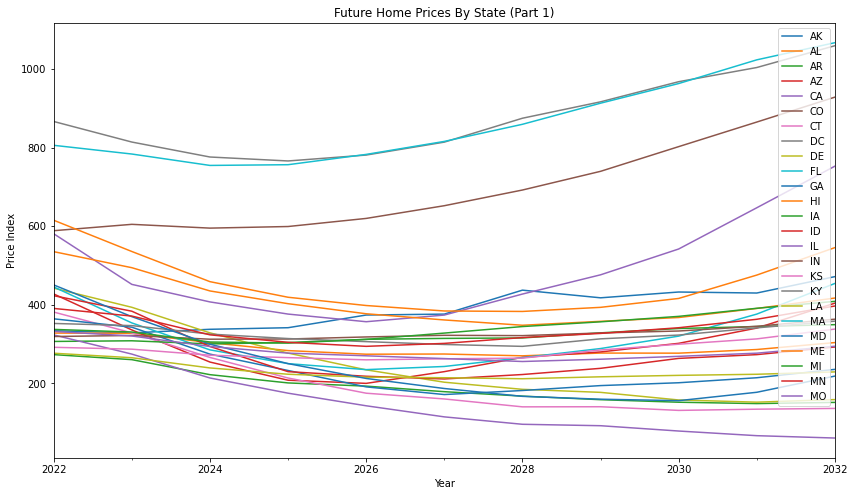

In [273]:
# Create a visualization of the data.
# Calculate the number of columns in the original dataframe
num_cols = len(predictions_df.columns)
half_cols = num_cols // 2

# Split the dataframe into two equal halves
df_predictions_1 = predictions_df.iloc[:, :half_cols]
df_predictions_2 = predictions_df.iloc[:, half_cols:]

df_predictions_1.plot(kind = 'line', figsize = (14, 8))

# Add the title and labels
plt.title('Future Home Prices By State (Part 1)')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.show()

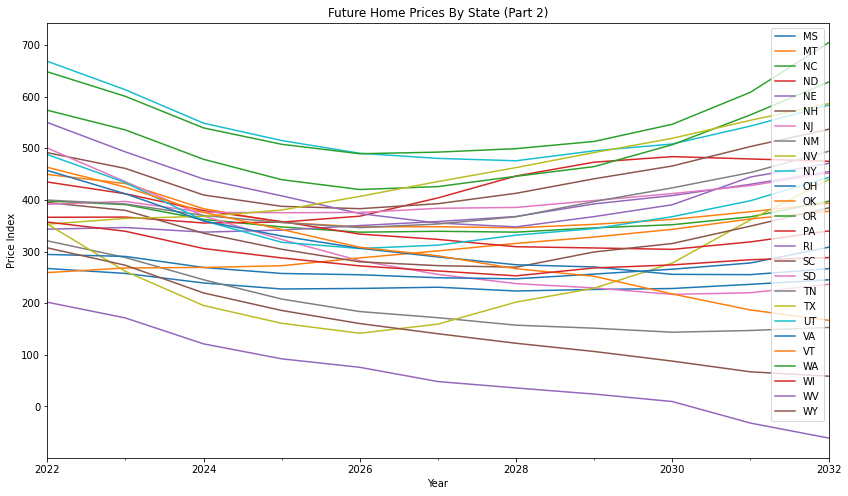

In [274]:
df_predictions_2.plot(kind = 'line', figsize = (14, 8))

# Add the title and labels
plt.title('Future Home Prices By State (Part 2)')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.show()

What we see in these graphs appears to match the initial assumption.  There are areas with high volatility that further express that volatility over the coming years.  The prediction estimates a recovery for the housing market roughly three to four years after the initial reduction period, similiar to previous data, while having some states be almost unaffected over the next seven years.  There are some outliers that show serious discordance with the rest of the data like WV and WY, but most states show a trend upwards similiar to the initial training data used.